Shape of dataset: (5000, 12)

Columns: ['customer_id', 'age', 'gender', 'time_on_site', 'pages_viewed', 'previous_purchases', 'device_type', 'traffic_source', 'day_of_week', 'time_of_day', 'region', 'made_purchase']

First 5 rows:
    customer_id   age  gender  time_on_site  pages_viewed  previous_purchases  \
0            1  40.0  Female          5.59             6                 1.0   
1            2  33.0    Male          7.02             3                 1.0   
2            3  42.0  Female         20.23             3                 2.0   
3            4  53.0  Female          0.40             5                 4.0   
4            5  32.0  Female          6.82             5                 2.0   

  device_type traffic_source day_of_week time_of_day   region  made_purchase  
0      Mobile         Direct      Monday     Morning    North              0  
1     Desktop         Search      Sunday     Evening  Central              1  
2     Desktop         Search      Sunday   Afterno

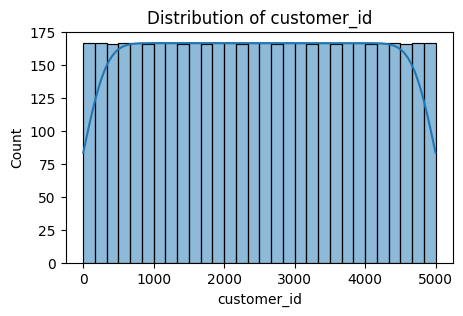

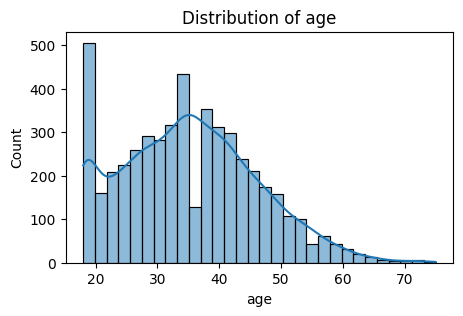

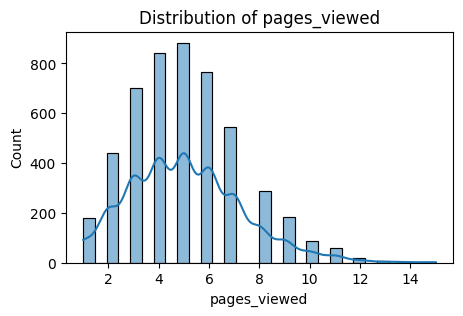

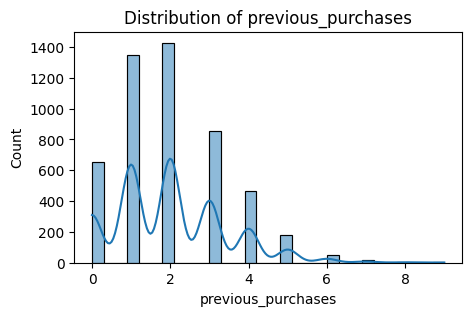

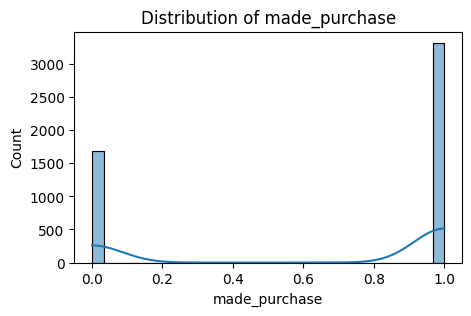


Selected Features (X): ['customer_id', 'age', 'time_on_site', 'pages_viewed', 'previous_purchases']
Target Variable (y): made_purchase

Training set: (4000, 5) Testing set: (1000, 5)

Model Evaluation:
MSE: 0.19804094759120136
RMSE: 0.4450179182810523
R² Score: 0.09287020836218429



Feature Importance (Impact on Gold Price):
               Feature   Coefficient
4  previous_purchases  5.147325e-02
3        pages_viewed  3.742491e-02
2        time_on_site  1.049795e-02
1                 age  1.226174e-03
0         customer_id  7.122381e-07


In [5]:
# 1. Load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load CSV
# Update the path to where your gold_price_data.csv file is located
df = pd.read_csv("/content/customer_purchase_data.csv")

# Display shape, columns, first 5 rows
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())

# 2. Missing values & duplicates
print("\nMissing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()

# Convert 'date' to datetime if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    # Extract useful time features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day

# Fill missing values (numeric → median, categorical → mode)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# 3. Exploratory Data Analysis (EDA)
print("\nDescriptive Statistics:\n", df.describe())

# Plot distributions for first 6 numeric features
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols[:6]:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# 4. Correlation Heatmap (numeric only)
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include='number').corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 5. Select Features (X) and Target (y)
# Set target column: use "close" or "adj_close"
target_col = "made_purchase"   # <-- change to "adj_close" if preferred

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# Independent variables = all numeric except target
features = [col for col in num_cols if col != target_col]

X = df[features]
y = df[target_col]

print("\nSelected Features (X):", features)
print("Target Variable (y):", target_col)

# 6. Train-Test Split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining set:", X_train.shape, "Testing set:", X_test.shape)

# 7. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Evaluate the Model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)

# 9. Plot Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Gold Prices")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.show()

# 10. Interpret Coefficients
coeff_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Impact on Gold Price):\n", coeff_df)